In [1]:
from transformer_lens import HookedTransformer
import torch
import matplotlib.pyplot as plt
import os
from jaxtyping import Float

torch.set_grad_enabled(False)

model = HookedTransformer.from_pretrained("gemma-2-2b", device="mps", dtype="float16")
torch.set_grad_enabled(False)

/Users/sudarshanagopalkunnavakkam/Documents/Github/Language Models Updating Priors/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 3/3 [00:13<00:00,  4.63s/it]


Loaded pretrained model gemma-2-2b into HookedTransformer


In [2]:
good_labels = """
France, Paris
Japan, Tokyo
Brazil, Brasília
Canada, Ottawa
Australia, Canberra
Germany, Berlin
India, New_Delhi
Italy, Rome
Russia,"""

# scramble labels
corrupted_labels = """
France, Ottawa
Japan, Brasília
Brazil, Rome
Canada, Tokyo
Australia, Berlin
Germany, New_Delhi
India, Canberra
Italy, Paris
Russia,"""

good_tokens = model.to_tokens(good_labels)
corrupted_tokens = model.to_tokens(corrupted_labels)

In [3]:
good_logits, good_cache = model.run_with_cache(good_tokens)
corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)

In [4]:
good_logits = model(good_tokens)

In [5]:
good_logits.shape

torch.Size([1, 38, 256000])

In [6]:
print(corrupted_cache.keys())

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.ln1_post.hook_scale', 'blocks.0.ln1_post.hook_normalized', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.ln2_post.hook_scale', 'blocks.0.ln2_post.hook_normalized', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1

In [7]:
print(corrupted_cache["blocks.0.attn.hook_z"].shape)

torch.Size([1, 38, 8, 256])


In [8]:
def generate_head_hook(head, curr_z):
    def replace_hook(z, hook):
        z[:, -1, head, :] = curr_z
        return z
    return replace_hook

arr = []

for layer in range(model.cfg.n_layers):
    arr.append([])
    for head in range(model.cfg.n_heads):
        # now we take the corrupted cache
        curr_z = corrupted_cache[f"blocks.{layer}.attn.hook_z"]
        curr_z = curr_z.clone()

        # batch pos head dim
        curr_z = curr_z[:, -1, head, :]

        hook = generate_head_hook(head, curr_z)
        model.blocks[layer].attn.hook_z.add_hook(hook)
        logits = model(good_tokens)

        # Calculate target distribution once
        target_distribution = torch.nn.functional.softmax(good_logits[:, -1, :], dim=-1)

        # Calculate cross-entropy
        cross_entropy = torch.nn.functional.cross_entropy(logits[:, -1, :].squeeze(0), target_distribution.squeeze(0))
        
        print(cross_entropy.item())
        arr[-1].append(cross_entropy.item())
        model.reset_hooks()

0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.3974609375
0.3974609375
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.3974609375
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.3974609375
0.397705078125
0.397705078125
0.3974609375
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.397705078125
0.3974609375
0.397705078125
0.397705078125
0.3974609375
0.397705078125
0.397705078125
0.397705078125
0.3974609375
0.397705078125
0.397705078125
0.397705078

In [9]:
arr = torch.tensor(arr)
arr.shape

torch.Size([26, 8])

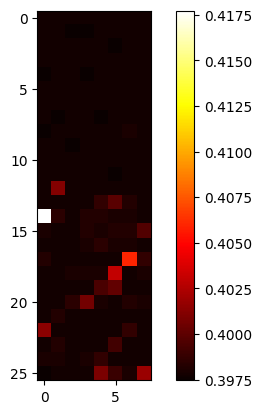

In [10]:
# arr is of shape (26, 8)
# plot it
plt.imshow(arr, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.show()

In [16]:
# get the indices of arr that are above a certain threshold
threshold = 0.001 + torch.mean(arr)

indices = torch.nonzero(arr > threshold, as_tuple=False)
indices

tensor([[12,  1],
        [13,  5],
        [14,  0],
        [15,  7],
        [17,  6],
        [18,  5],
        [19,  4],
        [19,  5],
        [20,  3],
        [22,  0],
        [23,  5],
        [25,  4],
        [25,  7]])

In [17]:
def generate_head_ablation_hook(head):
    def ablate_hook(z, hook):
        z[:, -1, head, :] = 0 
        return z
    return ablate_hook

for index in indices:
    layer, head = index
    layer = layer.item()
    head = head.item()

    hook = generate_head_ablation_hook(head)
    model.blocks[layer].attn.hook_z.add_hook(hook)

# now we make the model generate smth
ablated_logits = model(good_tokens)

topk = torch.topk(ablated_logits[:, -1, :].flatten(), 5, dim=-1)

model.tokenizer.convert_ids_to_tokens(topk.indices)




['▁Moscow', '\n', '▁London', '▁Paris', '▁Washington']